In [1]:
!unzip archive.zip

Archive:  archive.zip
  inflating: images/closedFist/IMG_20220430_180531.jpg  
  inflating: images/closedFist/IMG_20220430_180538.jpg  
  inflating: images/closedFist/IMG_20220430_180543.jpg  
  inflating: images/closedFist/IMG_20220430_180553.jpg  
  inflating: images/closedFist/IMG_20220430_180610.jpg  
  inflating: images/closedFist/IMG_20220430_180617.jpg  
  inflating: images/closedFist/IMG_20220430_180630.jpg  
  inflating: images/closedFist/IMG_20220430_182912.jpg  
  inflating: images/closedFist/IMG_20220430_182941.jpg  
  inflating: images/closedFist/IMG_20220430_182944.jpg  
  inflating: images/closedFist/IMG_20220430_182948.jpg  
  inflating: images/closedFist/IMG_20220430_182950.jpg  
  inflating: images/closedFist/IMG_20220430_182951.jpg  
  inflating: images/closedFist/IMG_20220430_182952.jpg  
  inflating: images/closedFist/IMG_20220501_151540.jpg  
  inflating: images/closedFist/IMG_20220501_151543.jpg  
  inflating: images/closedFist/IMG_20220501_151546.jpg  
  inflati

In [2]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Import from the correct module
import keras
from keras import layers
from keras import ops
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

In [3]:
dirname = glob.glob('/content/images/*')
dirname

['/content/images/fingerCircle',
 '/content/images/multiFingerBend',
 '/content/images/singleFingerBend',
 '/content/images/closedFist',
 '/content/images/openPalm',
 '/content/images/fingerSymbols',
 '/content/images/semiOpenFist',
 '/content/images/semiOpenPalm']

## 1 images from each classes

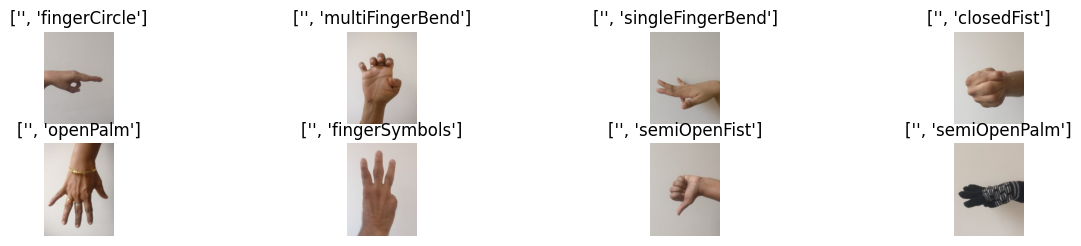

In [4]:
fig = plt.figure(figsize=(15, 7))
index=1
for i in dirname:
  plt.subplot(5,4,index)
  filenames = glob.glob(i+"/*jpg")
  img = cv2.imread(filenames[0])
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  plt.imshow(img)
  plt.axis('off')
  plt.title(i.split('/content/images/'))
  index=index + 1

## Teacher Network

In [6]:
def teacher_model():
  model = keras.models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(8, activation='softmax'))
  return model

## Student Network

In [7]:
def student_model():
  model = keras.models.Sequential()
  model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=(32, 32, 3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(8, activation='softmax'))
  return model

## loading the dataset

In [3]:
!pip install split-folders

In [4]:


import splitfolders

# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio("/content/images", output="output", seed=1337, ratio=(.8, .1, .1), group_prefix=None)

Copying files: 2167 files [00:00, 6724.89 files/s]


In [14]:
batch_size = 16

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    '/content/output/train',
    target_size=(32, 32),
    batch_size=batch_size
)

val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
    '/content/output/val',
    target_size=(32, 32),
    batch_size=batch_size
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    '/content/output/test',
    target_size=(32, 32),
    batch_size=batch_size,
    shuffle=False
)

Found 1731 images belonging to 8 classes.
Found 213 images belonging to 8 classes.
Found 223 images belonging to 8 classes.


In [22]:
teacher = teacher_model()
teacher.summary()
teacher.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_17 (Conv2D)                   │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 8)                   │          18,440 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 37,832 (147.78 KB)

 Trainable params: 37,832 (147.78 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
teacher.fit(train_generator, epochs=60, validation_data=val_generator)

Epoch 1/60
109/109 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.2325 - loss: 2.0069 - val_accuracy: 0.2441 - val_loss: 1.9815
Epoch 2/60
109/109 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.2430 - loss: 1.9686 - val_accuracy: 0.2817 - val_loss: 1.8478
Epoch 3/60
109/109 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.2967 - loss: 1.8332 - val_accuracy: 0.3474 - val_loss: 1.7089
Epoch 4/60
109/109 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.3379 - loss: 1.7356 - val_accuracy: 0.3521 - val_loss: 1.6677
Epoch 5/60
109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.3497 - loss: 1.6957 - val_accuracy: 0.4131 - val_loss: 1.5976
Epoch 6/60
109/109 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.3976 - loss: 1.5933 - val_accuracy: 0.4131 - val_loss: 1.5216
Epoch 7/60
109/109 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.4196 - loss: 1.5519 - val_accuracy: 0.4413 - val_loss: 1.5384
Epoch 8/60
109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.4290 - loss: 1.4997 - val_accu

In [30]:
teacher.evaluate(train_generator)

109/109 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.7908 - loss: 0.5735


[0.6071810722351074, 0.7850953340530396]

In [24]:
teacher.save('/content/drive/MyDrive/sensviz/teacher.h5')

## Distiler

In [33]:
class Distiller(keras.Model):
    def __init__(self, student, teacher):
        super().__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=3,
    ):
        super().compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def compute_loss(
        self, x=None, y=None, y_pred=None, sample_weight=None, allow_empty=False
    ):
        teacher_pred = self.teacher(x, training=False)
        student_loss = self.student_loss_fn(y, y_pred)

        distillation_loss = self.distillation_loss_fn(
            tf.nn.softmax(teacher_pred / self.temperature),  # Teacher soft predictions
            tf.nn.softmax(y_pred / self.temperature)         # Student soft predictions
        ) * (self.temperature ** 2)
        loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss
        # print("distillation_loss", loss)
        return loss

    def call(self, x):
        return self.student(x)


In [30]:
student = student_model()
student.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 30, 30, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 15, 15, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 3600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 8)                   │          28,808 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,256 (114.28 KB)

 Trainable params: 29,256 (114.28 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
teacher = keras.models.load_model('/content/drive/MyDrive/sensviz/teacher.h5')
teacher.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_17 (Conv2D)                   │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 8)                   │          18,440 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 37,834 (147.79 KB)

 Trainable params: 37,832 (147.78 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [21]:
teacher.evaluate(train_generator)

  2/109 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step - accuracy: 0.8906 - loss: 0.4874

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


109/109 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.7877 - loss: 0.6091


[0.6135659217834473, 0.7868283987045288]

In [35]:
distiller = Distiller(student=student, teacher=teacher)

distiller.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=['accuracy'],
    student_loss_fn=keras.losses.CategoricalCrossentropy(from_logits=False),
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.1,
    temperature=3
)

In [36]:
distiller.fit(train_generator, epochs=60)

Epoch 1/60
109/109 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.2816 - loss: 0.0000e+00
Epoch 2/60
109/109 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.3358 - loss: 0.0000e+00
Epoch 3/60
109/109 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - accuracy: 0.3278 - loss: 0.0000e+00
Epoch 4/60
109/109 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.3685 - loss: 0.0000e+00
Epoch 5/60
109/109 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - accuracy: 0.3931 - loss: 0.0000e+00
Epoch 6/60
109/109 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.3859 - loss: 0.0000e+00
Epoch 7/60
109/109 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - accuracy: 0.4070 - loss: 0.0000e+00
Epoch 8/60
109/109 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.4242 - loss: 0.0000e+00
Epoch 9/60
109/109 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.4269 - loss: 0.0000e+00
Epoch 10/60
109/109 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.4425 - loss: 0.0000e+00
Epoch 11/60
109/109 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.4699 - loss: 0.0000e

In [37]:
distiller.evaluate(train_generator)

109/109 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.6589 - loss: 0.0000e+00


[0.0, 0.0, 0.6574234366416931, 0.6574234366416931]

## Quantization
as u can see our prev srgan model take more than 300mb storage
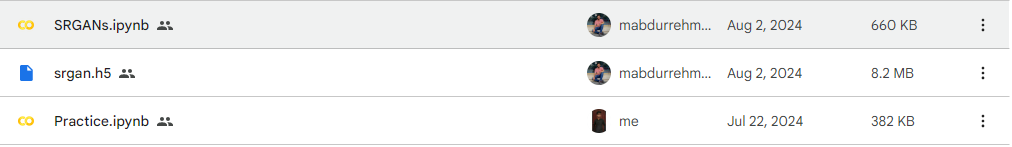

In [44]:
model = tf.keras.models.load_model("/content/drive/MyDrive/sensviz/srgan.h5")

In [45]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

Saved artifact at '/tmp/tmp_utt0tu1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='input_1')
Output Type:
  TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None)
Captures:
  138150923614192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138150923274016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138150923277888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138150923281936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138150923285104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138150923282112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138150923285632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138150923281760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138150923282464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138150923279296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13815092328

## With Quantization

In [47]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()

Saved artifact at '/tmp/tmpx1ss5ls3'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='input_1')
Output Type:
  TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None)
Captures:
  138150923614192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138150923274016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138150923277888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138150923281936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138150923285104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138150923282112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138150923285632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138150923281760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138150923282464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138150923279296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13815092328

In [48]:
len(tflite_model)

8179776

In [49]:
len(tflite_quant_model)

2118288

## as u can see that the size is decreased before quantization and after quantization

In [50]:
with open("tflite_model.tflite", "wb") as f:
    f.write(tflite_model)
with open("tflite_quant_model.tflite", "wb") as f:
    f.write(tflite_quant_model)

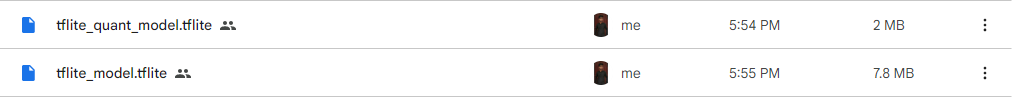